# Спектр Лапласа не распознаёт двудольность,
# Юдин Никита, 517 группа

Задача состоит в поиске пары графов, состоящих из $n$ вершин, у которых совпадает спектр Лапласа, но только один граф из пары должен быть двудольным. Данную задачу я решил набирающим популярность методом перебора возможных вариантов пар графов для нескольких $n$

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pickle as pkl
import warnings
warnings.simplefilter("ignore")
from collections import defaultdict

Функция генерации $n$ вершин для графа

In [2]:
def get_nodes(n):
    for i in range(1, n + 1):
        yield i

Функция генерации рёбер для полного графа, состоящего из $n$ вершин

In [3]:
def get_edges(n):
    for i in range(1, n + 1):
        for j in range(i + 1, n + 1):
            yield i, j

Функция, порождающая граф, состоящий из $n$ вершин, упорядоченный кодировкой множества рёбер бинарным вектором

In [4]:
def make_graph(n, counter):
    K = nx.Graph()
    K.add_nodes_from(get_nodes(n))
    mask = np.zeros(n * (n - 1) // 2, dtype=np.bool)
    num = np.array(list(bin(counter)[2:]), dtype=np.int64)
    mask[-num.size:] = num
    K.add_edges_from(np.array(list(get_edges(n)))[mask])
    return K, mask.sum()

Функция, удаляющая изоморфные графы из списка графов, состоящих из $n$ вершин

In [5]:
def delete_isomorphic(graph_list):
    for i in tqdm_notebook(range(len(graph_list)), desc='проверка на изоморфизм', leave=False):
        if graph_list[i] == 0:
            continue
        for j in range(i + 1, len(graph_list)):
            if graph_list[j] == 0:
                continue
            if nx.is_isomorphic(graph_list[i], graph_list[j]):
                graph_list[j] = 0
    res_list = []
    for i in tqdm_notebook(range(len(graph_list)), desc='сохранение графов', leave=False):
        if graph_list[i] == 0:
            continue
        res_list.append(graph_list[i])
    return res_list

Функция, находящая полным перебором искомые пары графов среди графов, состоящих из $n$ вершин

In [6]:
def iterate_through_graphs(n, eps=1e-8):
    max_counter = int(2 ** (n * (n - 1) // 2))
    
    cospectral_bi_notbi_pairs = []
    
    bipartite_graphs = defaultdict(list)
    not_bipartite_graphs = defaultdict(list)
    
    for i in tqdm_notebook(range(max_counter), desc='тест на двудольность', leave=False):
        Ki, num_of_nodes = make_graph(n, i)
        if nx.is_bipartite(Ki):
            bipartite_graphs[num_of_nodes].append(Ki)
            for j in range(len(bipartite_graphs[num_of_nodes]) - 1):
                if nx.is_isomorphic(Ki, bipartite_graphs[num_of_nodes][j]):
                    bipartite_graphs[num_of_nodes].pop()
                    break
        else:
            not_bipartite_graphs[num_of_nodes].append(Ki)
            for j in range(len(not_bipartite_graphs[num_of_nodes]) - 1):
                if nx.is_isomorphic(Ki, not_bipartite_graphs[num_of_nodes][j]):
                    not_bipartite_graphs[num_of_nodes].pop()
                    break
    
    #bipartite_graphs = delete_isomorphic(bipartite_graphs)
    #not_bipartite_graphs = delete_isomorphic(not_bipartite_graphs)
    
    bipartite_graphs_list = []
    not_bipartite_graphs_list = []
    
    for _, graphs in bipartite_graphs.items():
        bipartite_graphs_list.extend(graphs)
    
    for _, graphs in not_bipartite_graphs.items():
        not_bipartite_graphs_list.extend(graphs)
    
    for Ki in tqdm_notebook(bipartite_graphs_list, desc='двудольный граф', leave=False):
        for Kj in not_bipartite_graphs_list:
            if np.abs(nx.laplacian_spectrum(Ki) - nx.laplacian_spectrum(Kj)).max() < eps:
                cospectral_bi_notbi_pairs.append((Ki, Kj))
    
    return cospectral_bi_notbi_pairs

Поиск искомых пар графов для количества вершин, не превышающего 6

In [7]:
cospectral_bi_notbi_pairs = {}

for i in tqdm_notebook(range(1, 7), desc='количество вершин', leave=False):
    cospectral_bi_notbi_pairs[i] = iterate_through_graphs(i)

pkl.dump(cospectral_bi_notbi_pairs, open('graphs.pkl', 'wb'))

Загрузка результатов эксперимента из файла.

In [8]:
cospectral_bi_notbi_pairs = pkl.load(open('graphs.pkl', 'rb'))

Изображение первого найденного графа из первой пары на плоскости

In [9]:
def plotting(G):
    color_list = np.zeros(G.number_of_nodes(), dtype=np.int64)
    d = nx.coloring.greedy_color(G, strategy='largest_first')
    for n, c in d.items():
        color_list[n - 1] = c
    nx.draw(G, with_labels=True, node_color=color_list)
    plt.show()

Первый граф

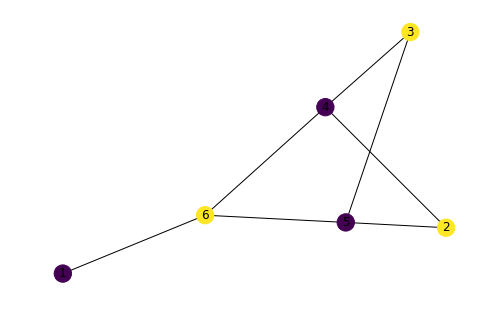

In [10]:
plotting(cospectral_bi_notbi_pairs[6][0][0])

Граф оказался двудольным

In [11]:
nx.is_bipartite(cospectral_bi_notbi_pairs[6][0][0])

True

Изображение второго найденного графа из первой пары на плоскости

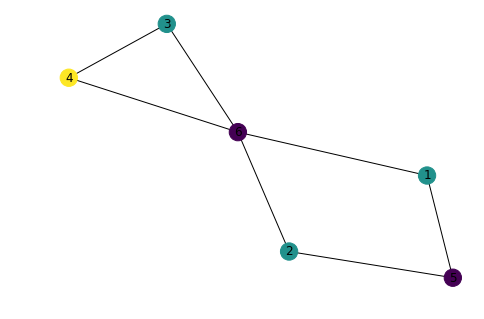

In [12]:
plotting(cospectral_bi_notbi_pairs[6][0][1])

Граф не двудольный

In [13]:
nx.is_bipartite(cospectral_bi_notbi_pairs[6][0][1])

False

Оказывается, среди рассмотренных графов с количеством вершин $n \leq 6$ такая пара единственная

In [14]:
for i in range(1, 7):
    print('Для %i вершин(ы) количество искомых пар равно %i'%(i, len(cospectral_bi_notbi_pairs[i])))

Для 1 вершин(ы) количество искомых пар равно 0
Для 2 вершин(ы) количество искомых пар равно 0
Для 3 вершин(ы) количество искомых пар равно 0
Для 4 вершин(ы) количество искомых пар равно 0
Для 5 вершин(ы) количество искомых пар равно 0
Для 6 вершин(ы) количество искомых пар равно 1


Спектр Лапласа найденного недвудольного графа

In [15]:
print(np.abs(nx.laplacian_spectrum(cospectral_bi_notbi_pairs[6][0][1])))

[8.02866726e-16 7.63932023e-01 2.00000000e+00 3.00000000e+00
 3.00000000e+00 5.23606798e+00]


Спектр Лапласа найденного двудольного графа

In [16]:
print(np.abs(nx.laplacian_spectrum(cospectral_bi_notbi_pairs[6][0][0])))

[2.27301449e-16 7.63932023e-01 2.00000000e+00 3.00000000e+00
 3.00000000e+00 5.23606798e+00]


В текущей реализации поиск подобных пар для 7 и более вершин требует существенно больше времени

In [17]:
for i in tqdm_notebook(range(7, 8), desc='количество вершин', leave=False):
    cospectral_bi_notbi_pairs[i] = iterate_through_graphs(i)

pkl.dump(cospectral_bi_notbi_pairs, open('graphs.pkl', 'wb'))

Загрузка результатов эксперимента из файла

In [18]:
cospectral_bi_notbi_pairs = pkl.load(open('graphs.pkl', 'rb'))

Изображение на плоскости найденных пар графов

In [19]:
def plot_pair(pair):
    color_list = np.zeros(pair[0].number_of_nodes(), dtype=np.int64)
    
    d = nx.coloring.greedy_color(pair[0], strategy='largest_first')
    
    for n, c in d.items():
        color_list[n - 1] = c
    
    fig = plt.figure(1)
    plt.clf()
    
    fig, ax = plt.subplots(1, 2, num=1)
    fig.set_size_inches(12,10)
    plt.sca(ax[0])
    
    pos = nx.nx_pydot.graphviz_layout(pair[0])
    
    nx.draw_networkx_nodes(pair[0], pos=pos, ax=ax[0], with_labels=True, node_color=color_list)
    nx.draw_networkx_edges(pair[0], pos=pos, ax=ax[0])
    
    ax[0].set_title('Двудольность: {0}'.format(nx.is_bipartite(pair[0])), fontsize=16)
    ax[0].set_axis_off()
    
    color_list = np.zeros(pair[1].number_of_nodes(), dtype=np.int64)
    
    d = nx.coloring.greedy_color(pair[1], strategy='largest_first')
    
    for n, c in d.items():
        color_list[n - 1] = c
    
    plt.sca(ax[1])
    
    pos = nx.nx_pydot.graphviz_layout(pair[1])
    
    nx.draw_networkx_nodes(pair[1], pos=pos, ax=ax[1], with_labels=True, node_color=color_list)
    nx.draw_networkx_edges(pair[1], pos=pos, ax=ax[1])
    
    ax[1].set_title('Двудольность: {0}'.format(nx.is_bipartite(pair[1])), fontsize=16)
    ax[1].set_axis_off()
    
    plt.show()

Пары графов

Для 6 вершин:
    пара № 1:


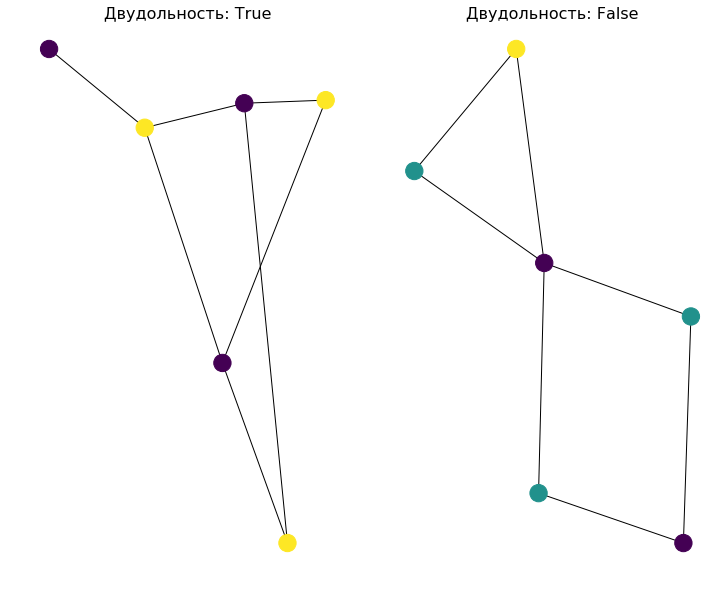

Для 7 вершин:
    пара № 1:


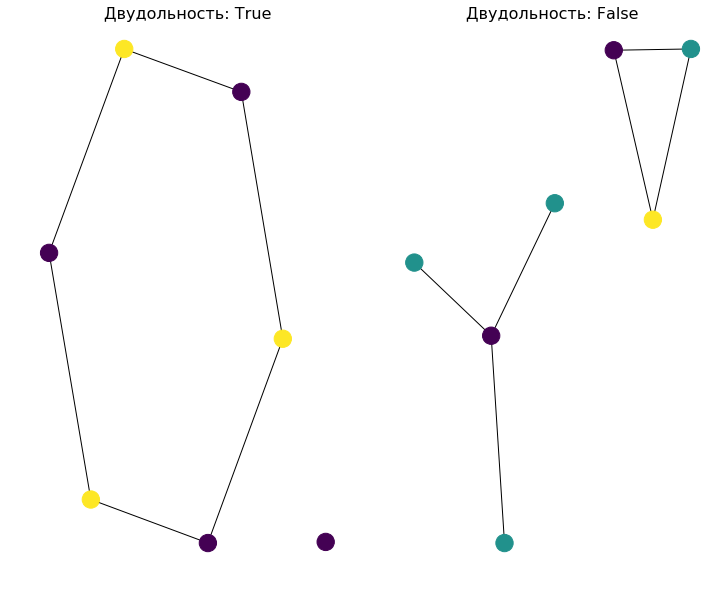

    пара № 2:


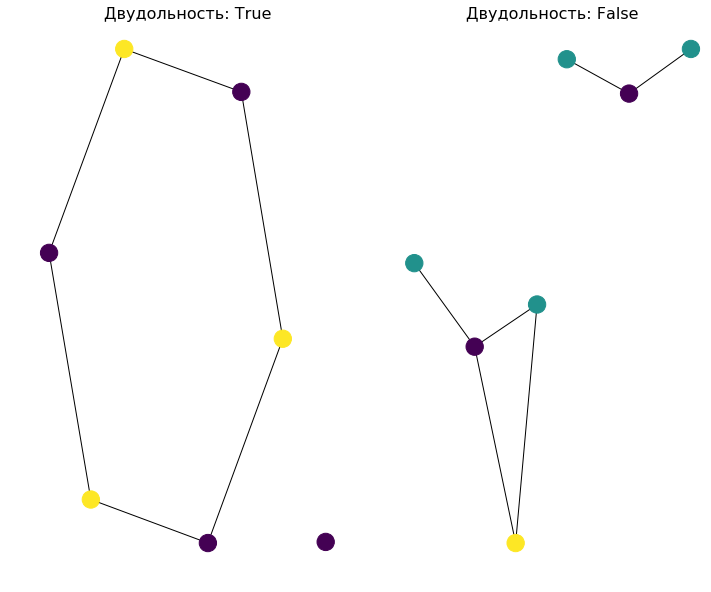

    пара № 3:


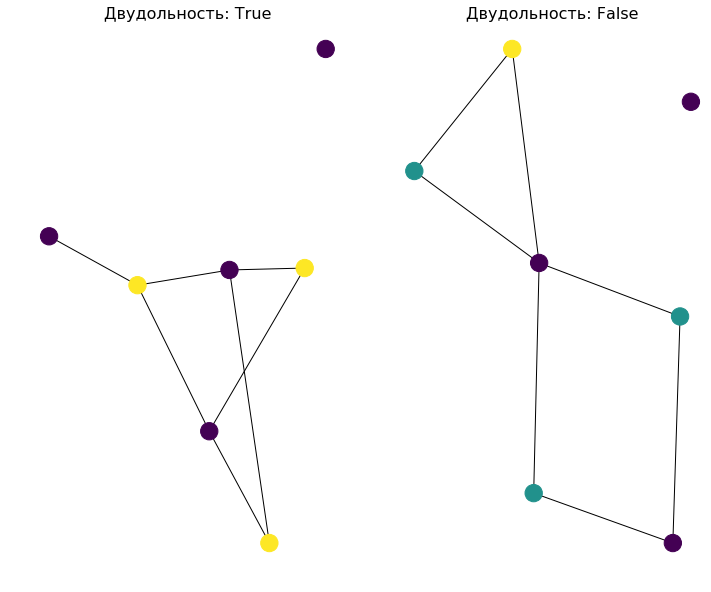

    пара № 4:


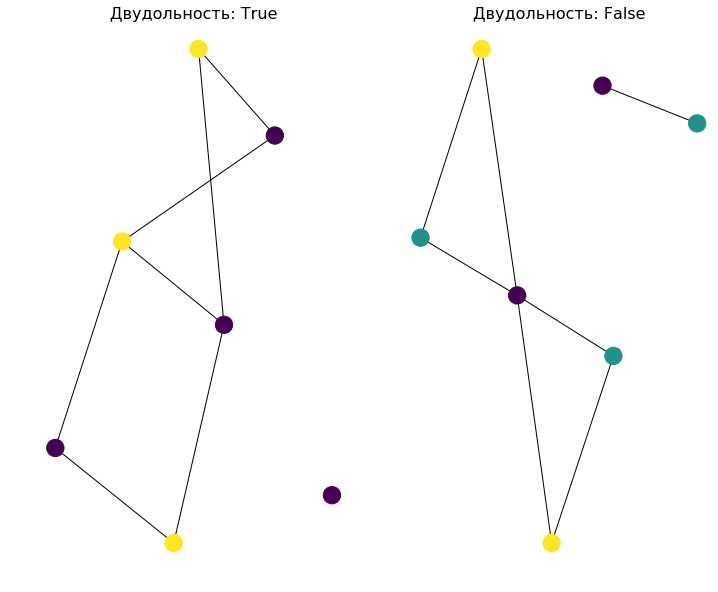

    пара № 5:


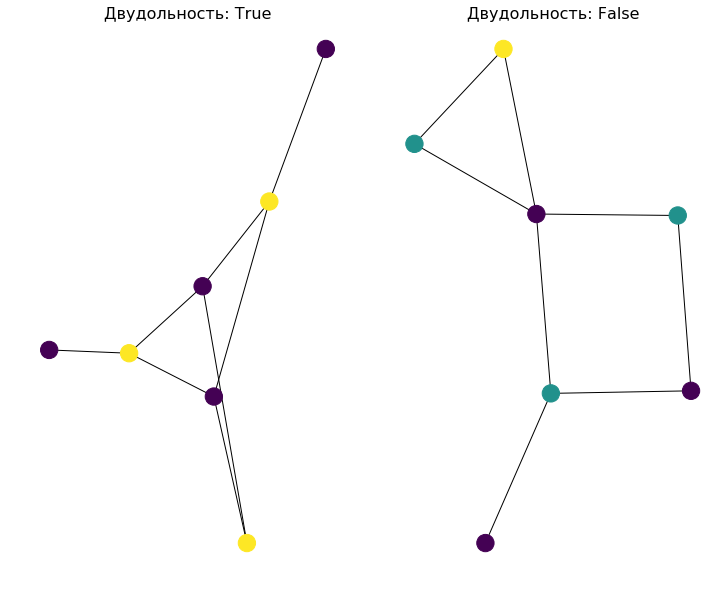

    пара № 6:


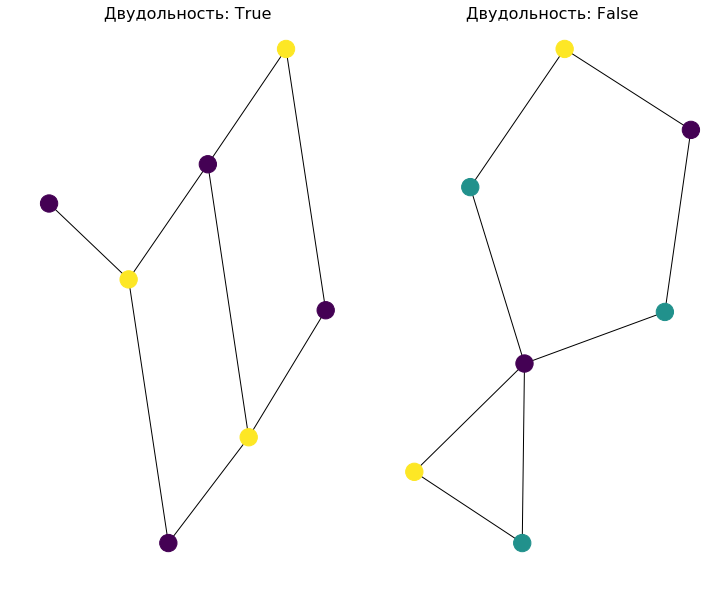

    пара № 7:


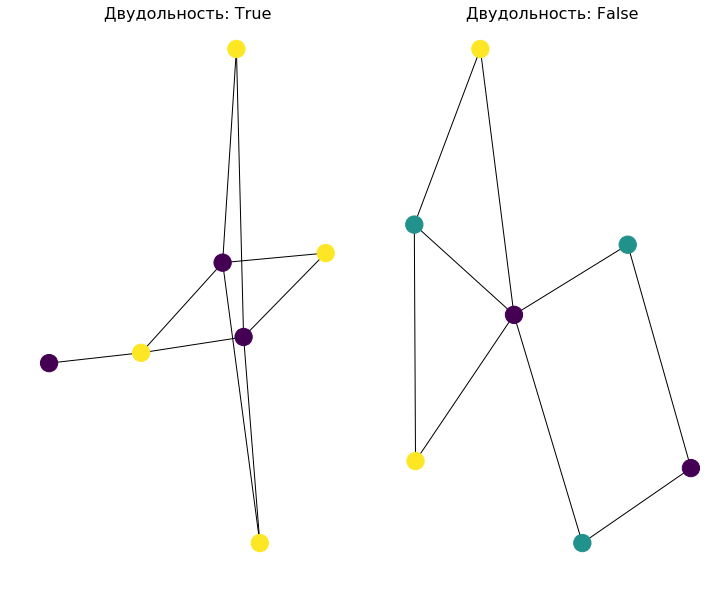

    пара № 8:


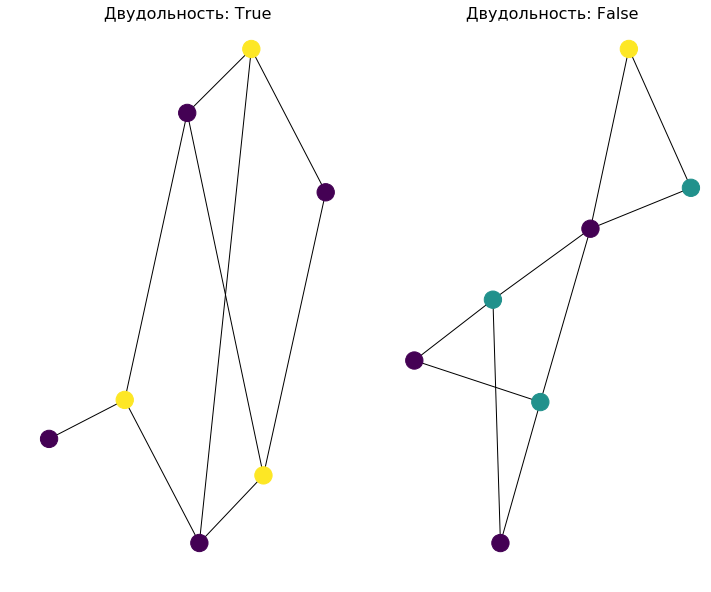

In [20]:
for num_of_nodes in [6, 7]:
    print('Для %i вершин:'%(num_of_nodes))
    for num, pair in enumerate(cospectral_bi_notbi_pairs[num_of_nodes]):
        print('    пара № %i:'%(num + 1))
        plot_pair(pair)